본 ipynb 파일은 초기 제공 코드를 한국어 주석만 추가하고 분석한 파일로, 원본 파일이 더 자세히 적혀있고 의역이 있을 수 있다.   

원본 파일 : 
ch1_nb1_build_and_train_neural_network_from_scratch.ipynb

In [ ]:
# !pip install numpy    # Numpy 라이브러리가 이미 있을 경우 그대로 진행/ 만약 없을 경우 Pip install 커맨드로 설치 요망
import numpy as np      # 행렬곱 연산을 수행하기 때문에 Numpy array 사용. numpy 임포트. 
np.random.seed(0)      # random.seed() 함수는 난수 생성에 필요한 시드를 설정 https://yjs-program.tistory.com/177 참고

## At the Beginning: the Neuron

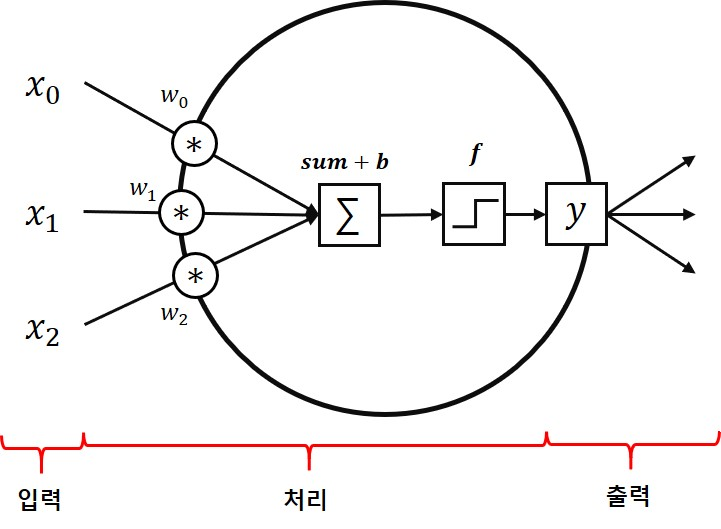

In [ ]:
class Neuron(object):
    """
    입력 벡터를 처리하여 activation function에 따라서 반환하는 인공 뉴런(Network가 아님)
    Args : 
        num_inputs(int): 입력 벡터 사이즈
        actviation_function(callable): Neuron 정의시 사용되는 활성화 함수
    Attributes :
        W(ndarray):각 입력 데이터의 Weight 값
        b(float): bias값 (Weight sum에 더해짐)
        activation_function (callable): 출력물 계산때 사용되는 activation function
    """

    def __init__(self, num_inputs, activation_function):
        super().__init__()

        # Weight vector랑 bias값을 무작위로 초기화(ex. -1~1사이의 단순한 분포)
        self.W = np.random.uniform(size=num_inputs, low=-1., high=1.)
        self.b = np.random.uniform(size=1, low=-1., high=1.)

        self.activation_function = activation_function

    def forward(self, x):
        """
        뉴런의 Forward 함수 
        Args:
            x (ndarray): (1, num_inputs) 크기의 input vector
        Returns:
            activation (ndarray): (1, layer_size)`크기의 activation function.
        """
        z = np.dot(x, self.W) + self.b
        # np.dot : 두 array의 dot product함수
        return self.activation_function(z)


이 클래스는 활성화 값을 반환하기 전에 입력 값의 벡터를 받아 병합 및 처리 할 수있는 간단한 인공 뉴런을 나타냅니다. 이제이 모델을 어떻게 사용할 수 있는지 보여 드리겠습니다.

참고 :이 클래스는 neuron.py에서도 찾을 수 있습니다.

먼저 뉴런을 인스턴스화합니다. 2 개의 입력 값을 취하고 그 활성화를 계산하기 위해 단계 함수를 사용하여 퍼셉트론 (c.f. 1 장)을 생성 해 보겠습니다. 가중치와 편향 값은 무작위로 설정됩니다.

In [ ]:
# 퍼셉트론의 Input Size:
input_size = 3

# Activation function==>Step function (returns 0 if y <= 0, or 1 if y > 0):
step_function = lambda y: 0 if y <= 0 else 1

# 뉴런클래스에 데이터 입력 후, Perceptron 데이터 받아오기:
perceptron = Neuron(num_inputs=input_size, activation_function=step_function)
print("Perceptron's random weights = {} , and random bias = {}".format(perceptron.W, perceptron.b))

Perceptron's random weights = [-0.25091976  0.90142861  0.46398788] , and random bias = [0.19731697]


우리는 뉴런에 공급할 3 개 값의 랜덤 입력 벡터 (즉, (shape = (1, 3))의 열 벡터)를 무작위로 생성합니다.

In [ ]:
x = np.random.rand(input_size).reshape(1, input_size)
print("Input vector : {}".format(x))

Input vector : [[0.15601864 0.15599452 0.05808361]]


Perceptron에 Input데이터를 공급하고, 관련 Activation 을 표시한다.

In [ ]:
y = perceptron.forward(x)
print("Perceptron's output value given `x` : {}".format(y))

Perceptron's output value given `x` : 1


## Layering Neurons Together

이전에 단순한 뉴런 하나를 구현했다면, 이제 뉴런을 여러 개 묶은 Fully Connected Layer예제를 분석해보자.

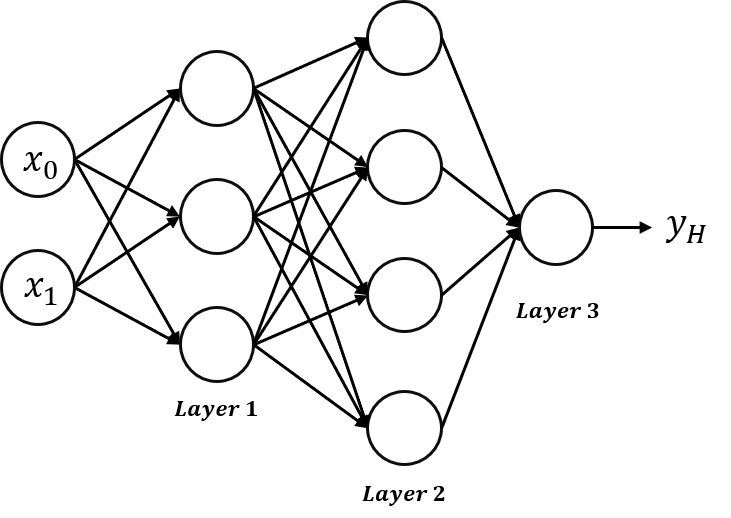

In [ ]:
class FullyConnectedLayer(object):
    """간단한 FC 신경망
    Args:
        num_inputs (int): 입력 벡터 크기 / 입력 값의 개수
        layer_size (int): 출력 벡터 크기 / 뉴런의 개수
        activation_function (callable): 이 계층에 사용할 Activation function
    Attributes:
        W (ndarray): 각 입력값에 대응되는 Weight
        b (ndarray): Weight sum(가중합)에 더해질 Bias 값
        size (int): 레이어 크기/뉴런 개수
        activation_function (callable): 뉴런에 적용할 Activation Function
        x (ndarray): 역전파를 위해 마지막에 제공되는 입력 벡터
        y (ndarray): 역전파로 사용되기 위해 x에 대응되는 출력값
        derivated_activation_function (callable): 역전파에 해당되는 파생함수
        dL_dW (ndarray): 가중치 W에 대한 Loss미분값
        dL_db (ndarray): 편향 b에 대한 Loss미분값
    """

    def __init__(self, num_inputs, layer_size, activation_function, derivated_activation_function=None):
        super().__init__()

        # 랜덤하게 Weight와 Bias를 초기화(정규 분포를 사용):
        self.W = np.random.standard_normal((num_inputs, layer_size))
        self.b = np.random.standard_normal(layer_size)
        self.size = layer_size

        self.activation_function = activation_function
        self.derivated_activation_function = derivated_activation_function
        self.x, self.y = None, None
        self.dL_dW, self.dL_db = None, None

    def forward(self, x):
        """
        layer에 대해서 Input vector에 대한 Forward함수 / 출력값은 Activation Function 적용된 값.
        Args:
            x (ndarray): (batch_size, num_inputs)사이즈의 입력 벡터
        Returns:
            activation (ndarray): (batch_size, layer_size)사이즈의 Activation vector
        """
        z = np.dot(x, self.W) + self.b
        self.y = self.activation_function(z)
        self.x = x  #역전파를 위해 입력, 출력물 저장
        return self.y

    def backward(self, dL_dy):
        """
        Loss를 역전파, 모든 미분을 계산하고 layer의 매개변수와 관련해 저장, backpropagation을 위해 Loss 반환

        Args:
            dL_dy (ndarray): 레이어 출력에 대한 Loss 미분 (dL/dy = l'_{k+1}).
        Returns:
            dL_dx (ndarray): 레이어 입력에 대한 Loss 미분 (dL/dx).
        """
        dy_dz = self.derivated_activation_function(self.y)  # = f'
        dL_dz = (dL_dy * dy_dz) # dL/dz = dL/dy * dy/dz = l'_{k+1} * f'
        dz_dw = self.x.T
        dz_dx = self.W.T
        dz_db = np.ones(dL_dy.shape[0]) # dz/db = d(W.x + b)/db = 0 + db/db = "ones"-vector

        # 최적화를 위해 각 lyaer의 매개변수와 관련된 미분값을 계산하고 저장함:
        self.dL_dW = np.dot(dz_dw, dL_dz)
        self.dL_db = np.dot(dz_db, dL_dz)

        # 입력에 대한 미분값을 계산하여 직전 레이어(`dL_dy`)로 전달:
        dL_dx = np.dot(dL_dz, dz_dx)
        return dL_dx

    def optimize(self, epsilon):
        """
        저장된 미분값을 사용해 레이어 매개변수를 최적화하는 과정
        Args:
            epsilon (float): 학습률.
        """
        self.W -= epsilon * self.dL_dW
        self.b -= epsilon * self.dL_db

앞에서 정의한 레이어를 사용하여 Input value를 하나씩 처리하거나 함께 batch에 넣어 처리해보도록 한다.

3개의 Neuron layer와 2개의 input value, ReLU를 활성화 함수로 사용한다.

fully_connected_layer.py에 동일하게 정의되어 있다.

In [ ]:
input_size    = 2
num_neurons   = 3
relu_function = lambda y: np.maximum(y, 0)

layer = FullyConnectedLayer(num_inputs=input_size, layer_size=num_neurons, activation_function=relu_function)

NameError: ignored

2개의 Input Value값을 랜덤으로 정의한다.

In [ ]:
x1 = np.random.uniform(-1, 1, 2).reshape(1, 2)
print("Input vector #1: {}".format(x1))

In [ ]:
x2 = np.random.uniform(-1, 1, 2).reshape(1, 2)
print("Input vector #2: {}".format(x2))

여기서 각 레이어를 한번씩 차례대로 실행하는 방법도 존재하고

In [ ]:
y1 = layer.forward(x1)
print("Layer's output value given `x1` : {}".format(y1))

In [ ]:
y2 = layer.forward(x2)
print("Layer's output value given `x2` : {}".format(y2))

아예 두 입력 벡터를 하나로 연결하여 각 layer에 한꺼번에 넣는 방법도 존재한다.

결과물을 보면 이전에 따로 실행됐던 결과물과 동일한 값으로 구성된 레이어가 등장하는 것을 볼 수 있다.

In [ ]:
x12 = np.concatenate((x1, x2))  # input vectors를(2, 2)`로 연결
y12 = layer.forward(x12)
print("Layer's output value given `[x1, x2]` :\n{}".format(y12))

## Implementing a Complete Neural Network

신경망의 목적은 비선형 예측을 수행하기 위함으로

Gradient descent(경사하강법)을 적용하여 올바른 예측을 수행하도록 훈현한다.

이를 위해 학습에 필요한 Loss함수와 네트워크의 성능 평가를 위한 부가적인 함수를 정의해보자. 

이번에는 앞서 정의한 FC Network를 토대로 classification network를 구현한다.

In [ ]:
def sigmoid(x):             # sigmoid function
    y = 1 / (1 + np.exp(-x))
    return y


def derivated_sigmoid(y):   # sigmoid derivative function(Sigmoid의 미분함수(도함수))
    return y * (1 - y)

Classification을 위한 네트워크를 위해 L2 or Cross-entropy Loss를 함께 구현하였다.

In [ ]:
def loss_L2(pred, target):             # L2 loss function
    return np.sum(np.square(pred - target)) / pred.shape[0] # opt. we divide by the batch size


def derivated_loss_L2(pred, target):   # L2 derivative function(L2 loss의 도함수)
    return 2 * (pred - target)

In [ ]:
def binary_cross_entropy(pred, target):            # cross-entropy loss function
    return -np.mean(np.multiply(np.log(pred), target) + np.multiply(np.log(1 - pred), (1 - target)))


def derivated_binary_cross_entropy(pred, target):  # cross-entropy derivative function
    return (pred - target) / (pred * (1 - pred))

As described in the book, we should now connect everything together, building a class able to connect multiple neural layers together, able to to feed-forward data through these layers and back-propagate the loss' gradients for training:

In [ ]:
class SimpleNetwork(object):
    """간단한 완전연결신경망 예제
    Args:
        num_inputs (int): The input vector size / number of input values.
        num_outputs (int): The output vector size.
        hidden_layers_sizes (list): Network에 더해지는 각각의 hidden layer의 사이즈를 담은 리스트
        activation_function (callable): 모든 레이어에 대한 Activation function
        derivated_activation_function (callable): 미분된 activation function
        loss_function (callable): 네트워크 학습을 위한 Loss함수
        derivated_loss_function (callable): 역전파를 위해 미분된 Loss function
    Attributes:
        layers (list): 네트워크를 구성하는 레이어 리스트.
        loss_function (callable): 네트워크 학습을 위한 Loss 함수
        derivated_loss_function (callable): 역전파를 위해 미분된 loss함수
    """

    def __init__(self, num_inputs, num_outputs, hidden_layers_sizes=(64, 32),
                 activation_function=sigmoid, derivated_activation_function=derivated_sigmoid,
                 loss_function=loss_L2, derivated_loss_function=derivated_loss_L2):
        super().__init__()
        # 제공된 인수에 따라 네트워크 구성
        layer_sizes = [num_inputs, *hidden_layers_sizes, num_outputs]# 레이어 사이즈 : [입력 크기, hidden 레이어 사이즈, 출력 크기]

        self.layers = [
            FullyConnectedLayer(layer_sizes[i], layer_sizes[i + 1], 
                                activation_function, derivated_activation_function)
            for i in range(len(layer_sizes) - 1)]
        # 레이어의 개수만큼 FClayer를 여러개 겹치게끔 구성

        self.loss_function = loss_function
        self.derivated_loss_function = derivated_loss_function

    def forward(self, x):
        """
        Input Vector가 Layer를 지나는 Forward함수
        Args:
            x (ndarray):(batch_size, num_inputs)` 사이즈의 Input Vector
        Returns:
            activation (ndarray): (batch_size, layer_size) 사이즈의 Activation Function
        """
        for layer in self.layers: 
            x = layer.forward(x)# 입력데이터를 layer에 입력, 출력물 받기
        return x

    def predict(self, x):
        """
        input x에 대하여 계산후, 가장 큰 index를 결과물을 산출
        Args:
            x (ndarray): (1, num_inputs) 크기의 input size
        Returns:
            best_class (int): 예측 클래스 아이디
        """
        estimations = self.forward(x)# 입력 데이터(x)를 제공 후, output vector를 estimation으로 받고,
        best_class = np.argmax(estimations)# 그 중 가장 큰 값을 최종 예측 클래스로 산출
        return best_class

    def backward(self, dL_dy):
        """
        Network에서 Loss를 역전파하는 과정 (Forward 함수 다음에 수행되어야 함)
        Args:
            dL_dy (ndarray): Network의 output(y)에 대한 미분값
        Returns:
            dL_dx (ndarray): Network의 input(x)에 대한 미분값
        """
        for layer in reversed(self.layers): # 
            dL_dy = layer.backward(dL_dy) # 역전파시 거꾸로
        return dL_dy

    def optimize(self, epsilon):
        """
        저장해둔 Gradient를 토대로 네트워크 최적화(backward 함수 다음에 수행되어야 함)
    
        Args:
            epsilon (float): The learning rate. 학습률
        """
        for layer in self.layers: # 순서는 상관 X
            layer.optimize(epsilon)

    def evaluate_accuracy(self, X_val, y_val):
        """
        데이터셋과 대응되는 정답 Label을 제공후, 현재 네트워크의 정확도를 측정
        Given a dataset and its ground-truth labels, evaluate the current accuracy of the network.
        Args:
            X_val (ndarray): 네트워크에 입력할 검증용 데이터 
            y_val (ndarray): 검증용 데이터에 대응되는 정답 
        Returns:
            accuracy (float): 네트워크 정확도(정답 데이터셋 개수/전체 데이터셋 개수)
        """
        num_corrects = 0
        for i in range(len(X_val)):
            pred_class = self.predict(X_val[i])
            if pred_class == y_val[i]:
                num_corrects += 1
        return num_corrects / len(X_val)

    def train(self, X_train, y_train, X_val=None, y_val=None, 
              batch_size=32, num_epochs=5, learning_rate=1e-3, print_frequency=20):
        """
        데이터셋, 정답 라벨 제공, 현 네트워크에 대한 정확도 측정
        Args:
            X_train (ndarray): The input training dataset.
            y_train (ndarray): The corresponding ground-truth training dataset.
            X_val (ndarray): The input validation dataset.
            y_val (ndarray): The corresponding ground-truth validation dataset.
            batch_size (int): The mini-batch size.학습 때 사용하는 mini-batch 사이즈
            num_epochs (int): The number of training epochs i.e. iterations over the whole dataset. Epoch수
            learning_rate (float): The learning rate to scale the derivatives.
            print_frequency (int): Frequency to print metrics (in epochs).
        Returns:
            losses (list): The list of training losses for each epoch.
            accuracies (list): The list of validation accuracy values for each epoch.
        """
        num_batches_per_epoch = len(X_train) // batch_size # train데이터에 대한 batch size측정
        do_validation = X_val is not None and y_val is not None # 검증단계 여부를 결정하는 변수
        losses, accuracies = [], []
        for i in range(num_epochs): # for each training epoch 전체 Epoch 횟수만큼 반복
            epoch_loss = 0
            for b in range(num_batches_per_epoch):  # for each batch composing the dataset 데이터셋을 구성하는 각 batch마다
                # Get batch:
                batch_index_begin = b * batch_size  # batch index의 시작 지점
                batch_index_end = batch_index_begin + batch_size # batch index의 끝 지점
                x = X_train[batch_index_begin: batch_index_end] # Train 데이터
                targets = y_train[batch_index_begin: batch_index_end] # targets(정답 데이터)
                # Optimize on batch:
                predictions = y = self.forward(x)  # 입력 데이터, Network에 forward한 후 결과값 받아오기
                L = self.loss_function(predictions, targets)  # 예측한 결과물에 따라 Loss 계산
                dL_dy = self.derivated_loss_function(predictions, targets)  # Loss 미분
                self.backward(dL_dy)  # 네트워크 역전파 진행
                self.optimize(learning_rate)  # optimization of the NN 최적화 진행
                epoch_loss += L

            # Logging training loss and validation accuracy, to follow the training:
            # 매순간 Traning을 진행하면서 Loss와 Accuracy 출력
            epoch_loss /= num_batches_per_epoch
            losses.append(epoch_loss)
            if do_validation:
                accuracy = self.evaluate_accuracy(X_val, y_val)
                accuracies.append(accuracy)
            else:
                accuracy = np.NaN
            if i % print_frequency == 0 or i == (num_epochs - 1):
                print("Epoch {:4d}: training loss = {:.6f} | val accuracy = {:.2f}%".format(
                    i, epoch_loss, accuracy * 100))
        return losses, accuracies

***Note:*** This class can also be found in [simple_network.py](simple_network.py).


## Applying our Network to Classification

Using untrained perceptrons and layers on random inputs is however a bit dull. In this final section of the notebook, we instantiate and train our simple model to ***classify images of hand-written digits***. 


### Setting up the Task

For this task, we will use the the [MNIST dataset](http://yann.lecun.com/exdb/mnist) presented in the book[$^2$](#ref) (Yann LeCun and Corinna Cortes hold all copyrights for this dataset).

Before implementing a solution, we should prepare the data, loading the MNIST images for training and testing methods. For simplicity, we will use the Python module [`mnist`](https://github.com/datapythonista/mnist) developed by [Marc Garcia](https://github.com/datapythonista), and already installed in this chapter's directory (see [`./mnist/`](mnist/__init__.py)).

In [ ]:
%matplotlib inline
# !pip install matplotlib  # Uncomment and run if matplotlib is not installed yet.
import matplotlib          # We use this package to visualize some data and results
import matplotlib.pyplot as plt
import mnist

np.random.seed(42)

The `mnist` module makes it simple to load the training and testing data (images and their labels):

In [ ]:
X_train, y_train = mnist.train_images(), mnist.train_labels()
X_test,  y_test  = mnist.test_images(), mnist.test_labels()
num_classes = 10    # classes are the digits from 0 to 9

We can check the number and size of the training/testing samples:

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
X_test.shape

(10000, 28, 28)

i.e. we have 60,000 training samples and 10,000 testing one, with each sample an image of $28 \times 28$ pixels.

We can have a look at the data, for instance using `matplotlib`:

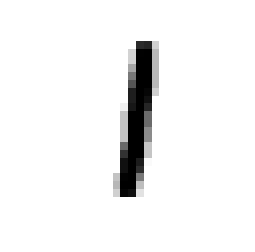

In [ ]:
img_idx = np.random.randint(0, X_test.shape[0])
plt.imshow(X_test[img_idx], cmap=matplotlib.cm.binary)
plt.axis("off")
plt.show()

In [ ]:
y_test[img_idx]

1

As we can see, our images match their ground-truth label, which is good news!

However, as our network only accepts column vectors, we need to _flatten_ the images into 1D vectors, i.e. vectors of shape `(1, 784)` (since $28 \times 28 = 784$):

In [ ]:
X_train, X_test = X_train.reshape(-1, 28 * 28), X_test.reshape(-1, 28 * 28)

Also, let us have a look at our pixel values:

In [ ]:
print("Pixel values between {} and {}".format(X_train.min(), X_train.max()))

Pixel values between 0 and 255


Those are normal integer values for images with 8 bits per channel (`uint8`)... These values may be however too big for some of our operations. For instance, given a too big input value, our sigmoid may return `nan` ("_not a number_") because of the exponential function it uses, which may "overflow" with a large input value.

It is thus customary to *normalize* the input data, i.e. to scale the values between 0 and 1 (or -1 and 1):

In [ ]:
X_train, X_test = X_train / 255., X_test / 255.
print("Normalized pixel values between {} and {}".format(X_train.min(), X_train.max()))

Normalized pixel values between 0.0 and 1.0


Finally, to compute the loss, we need to ***one-hot*** the labels, e.g. converting the label `4` into `[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]`:

In [ ]:
y_train = np.eye(num_classes)[y_train]

### Instantiating the Network

Time to prepare the classifier itself. Let us use our `SimpleNetwork` class and instantiate a network with 2 hidden layers, taking a flattened image as input and returning a 10-value vector representing its belief the image belongs to each of the class (the highter the value,the stronger the belief): 

In [ ]:
mnist_classifier = SimpleNetwork(num_inputs=X_train.shape[1], 
                                 num_outputs=num_classes, hidden_layers_sizes=[64, 32])

We can now check how our network performs (computing its *loss* over the training set, and its *accuracy* over the test set):

In [ ]:
predictions = mnist_classifier.forward(X_train)                         # forward pass
loss_untrained = mnist_classifier.loss_function(predictions, y_train)   # loss computation

accuracy_untrained = mnist_classifier.evaluate_accuracy(X_test, y_test)  # Accuracy
print("Untrained : training loss = {:.6f} | val accuracy = {:.2f}%".format(
    loss_untrained, accuracy_untrained * 100))

Untrained : training loss = 4.436700 | val accuracy = 12.19%


... This is a really poor performance... But as we know from the book, this is to be expected: we have yet to train our network

### Teaching our Network to Classify

This is where things finally get interesting. As the whole training procedure is already explained and implemented, we simply have to launch it (note: the training takes minutes/hours):

In [ ]:
losses, accuracies = mnist_classifier.train(X_train, y_train, X_test, y_test, 
                                            batch_size=30, num_epochs=500)
# note: Reduce the batch size and/or number of epochs if your computer can't 
#       handle the computations / takes too long.
#       Remember, numpy also uses the CPU, not GPUs as modern Deep Learning 
#       libraries do, hence the lack of computational performance here.

Epoch    0: training loss = 1.096978 | val accuracy = 19.10%
Epoch   20: training loss = 0.252953 | val accuracy = 84.89%
Epoch   40: training loss = 0.177532 | val accuracy = 88.92%
Epoch   60: training loss = 0.146596 | val accuracy = 90.50%
Epoch   80: training loss = 0.128075 | val accuracy = 91.29%
Epoch  100: training loss = 0.114770 | val accuracy = 92.01%
Epoch  120: training loss = 0.104585 | val accuracy = 92.39%
Epoch  140: training loss = 0.096663 | val accuracy = 92.74%
Epoch  160: training loss = 0.090176 | val accuracy = 93.06%
Epoch  180: training loss = 0.084631 | val accuracy = 93.22%
Epoch  200: training loss = 0.079820 | val accuracy = 93.46%
Epoch  220: training loss = 0.075625 | val accuracy = 93.66%
Epoch  240: training loss = 0.071941 | val accuracy = 93.72%
Epoch  260: training loss = 0.068681 | val accuracy = 93.93%
Epoch  280: training loss = 0.065795 | val accuracy = 94.12%
Epoch  300: training loss = 0.063194 | val accuracy = 94.28%
Epoch  320: training los

Almost **95%** of accuracy! This is much better. Congratulations, we implemented and trained our first neural network classifier!

Finally, we can plot the evolution of the loss and accuracy during the training, to better visualize the evolution:

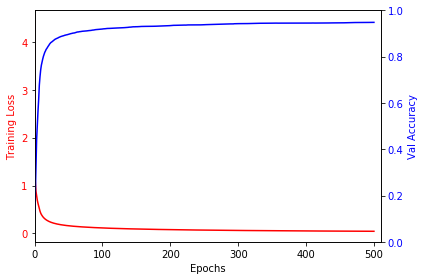

In [ ]:
losses, accuracies = [loss_untrained] + losses, [accuracy_untrained] + accuracies
fig, ax_loss = plt.subplots()

color = 'red'
ax_loss.set_xlim([0, 510])
ax_loss.set_xlabel('Epochs')
ax_loss.set_ylabel('Training Loss', color=color)
ax_loss.plot(losses, color=color)
ax_loss.tick_params(axis='y', labelcolor=color)

ax_acc = ax_loss.twinx()  # instantiate a second axes that shares the same x-axis
color = 'blue'
ax_acc.set_xlim([0, 510])
ax_acc.set_ylim([0, 1])
ax_acc.set_ylabel('Val Accuracy', color=color)
ax_acc.plot(accuracies, color=color)
ax_acc.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

As we can see, our network *converged* quite fast, though the accuracy slowly kept increasing. It looks even like the accuracy could still go up a bit with some further training iterations... We leave it to our readers to check. 

Before concluding this notebook, let us verify how our network is now performing on our random test image:

In [ ]:
# We use `np.expand_dims(x, 0)` to simulate a batch (transforming the image shape
# from (784,) to (1, 784)):
predicted_class = mnist_classifier.predict(np.expand_dims(X_test[img_idx], 0))
print('Predicted class: {}; Correct class: {}'.format(predicted_class, y_test[img_idx]))

Predicted class: 1; Correct class: 1


## Conclusion

Through this first notebook, we illustrated the main notions of Chapter 1, starting with the implementation of a single artificial neuron and ending up with a network compose of several thousand neurons, able to classify digits with a decent accuracy.

Training this network was however a slow process. In the next chapter and related notebooks, we will finally get started with TensorFlow 2 and Keras, to easily scale up our use-cases!

<a id="ref"></a>
#### References

1. Rosenblatt, F., 1958. The perceptron: a probabilistic model for information storage and organization in the brain. Psychological review 65, 386.
2. LeCun, Y., Cortes, C., Burges, C., 2010. MNIST handwritten digit database. AT&T Labs [Online]. Available: http://yann.lecun.com/exdb/mnist 2, 18.